### Modelo de Churn - Base Geral

###### Importações

In [4]:
import pandas as pd
import nbformat
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.linear_model import LogisticRegression
import pickle
import hmac
import hashlib

###### Base de dados

In [5]:
### https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn

### Pré-processamento de dados

In [6]:
df = pd.read_csv('../dataset/customerChurnRecords.csv').drop(columns=['RowNumber', 'CustomerId', 'Gender'])
display(df.columns)

Index(['Surname', 'CreditScore', 'Geography', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited', 'Complain', 'Satisfaction Score', 'Card Type',
       'Point Earned'],
      dtype='object')

In [7]:
# Removendo outliers
df = df.query("CreditScore > 383 & CreditScore < 850 & Age > 20 & Age < 62 & Tenure > 2 & Exited == 0")

In [8]:
# Automatico
df['AgeSeg'] = pd.cut(df['Age'], bins=8, right=False, labels=False) + 1
df['BalanceSeg'] = pd.cut(df['Balance'], bins=10, right=False, labels=False) + 1
df['EstimatedSalarySeg'] = pd.cut(df['EstimatedSalary'], bins=10, right=False, labels=False) + 1
df['PointEarnedSeg'] = pd.cut(df['Point Earned'], bins=10, right=False, labels=False) + 1
df['CreditScoreSeg'] = pd.cut(df['CreditScore'], bins=5, right=False, labels=False) + 1

# Na mão
# Credit Card Type
def CreditCardType(x):
    if x == 'SILVER':
        return 1
    elif x == 'GOLD':
        return 2
    elif x == 'PLATINUM':
        return 3
    else:
        return 4
    
# Credit Card Type
def Geography(x):
    if x == 'France':
        return 1
    elif x == 'Spain':
        return 2
    elif x == 'Germany':
        return 3

df['CCT'] = df['Card Type'].apply(CreditCardType)
df['Geo'] = df['Geography'].apply(Geography)
df = df.drop(columns=['Card Type', 'Surname', 'Geography'])

df['CSSatisfaction'] = df['Satisfaction Score'] / df['CreditScoreSeg']
df['CSSatisfaction'] = df['CSSatisfaction'].apply(lambda x: 1 if x > 1 else 2)


### IA - Base Geral

###### Serialização

In [9]:
def desserializar_e_verificar(chave, arquivo):
    dados_assinados = arquivo.read()
    obj_serializado = dados_assinados[:-32]
    assinatura = dados_assinados[-32:]
    assinatura_gerada = hmac.new(chave, obj_serializado, hashlib.sha256).digest()
    if hmac.compare_digest(assinatura, assinatura_gerada):
        return pickle.loads(obj_serializado)
    else:
        raise ValueError('Assinatura invalida')

def serializar_assinar(objeto, chave, arquivo):
    obj_serializado = pickle.dumps(objeto)
    assinatura = hmac.new(chave, obj_serializado, hashlib.sha256).digest()
    dados_assinados = obj_serializado + assinatura
    arquivo.write(dados_assinados)

###### Divisão da base

In [10]:
resposta = pd.DataFrame(df['IsActiveMember'])
atributos = df.drop('IsActiveMember', axis=1)
x_train, x_test, y_train, y_test = train_test_split(atributos, resposta, test_size=.25, random_state=1)


###### Naive Bayes

c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acurácia: 51.26%


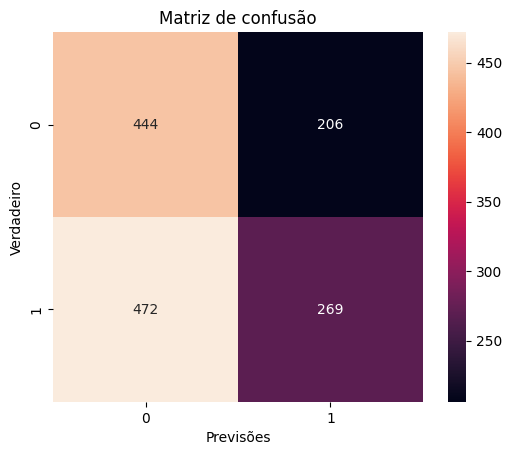

In [11]:
# Criando o NB
model_nb = GaussianNB()
model_nb.fit(x_train, y_train)

# Realizando o teste
predicted_model_nb = model_nb.predict(x_test)

accuracia_model_nb = accuracy_score(y_test, predicted_model_nb)
print(f"Acurácia: {(accuracia_model_nb * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_nb = confusion_matrix(y_test, predicted_model_nb)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_nb, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel ('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Serializar
with open('modelos/geral/dados_serializados_model_nb.pickle', 'wb') as arquivo:
    serializar_assinar(model_nb, b'M4Mm]_g#{T', arquivo)
    
    
# desserializar
with open('modelos/geral/dados_serializados_model_nb.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Gini

Acurácia: 53.27%


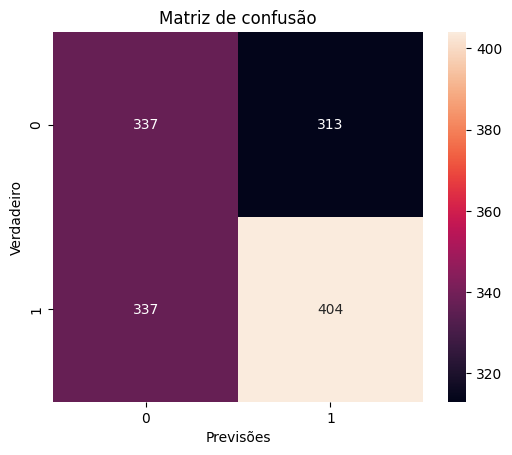

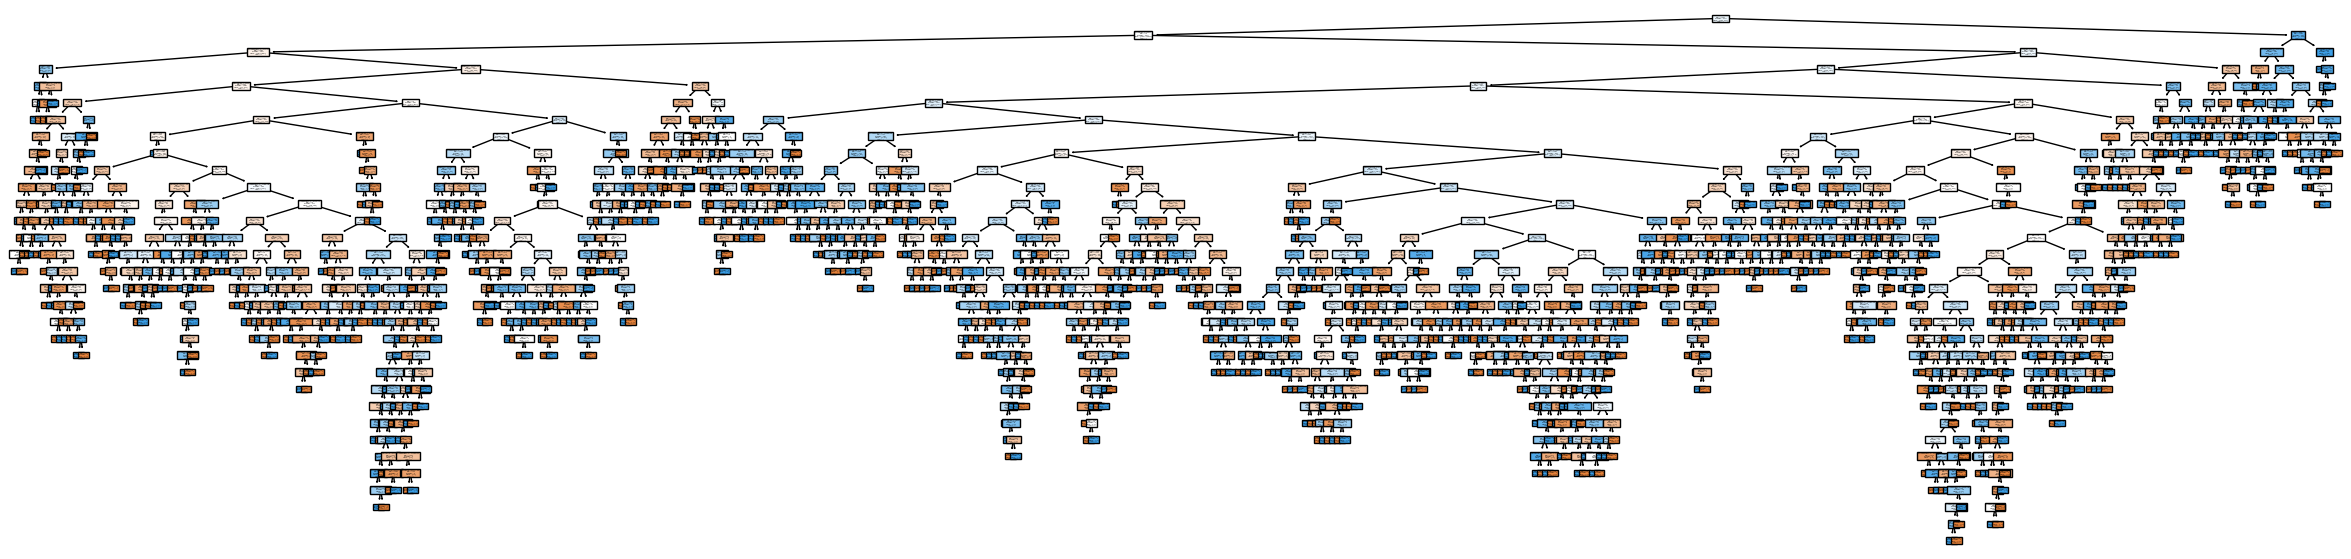

In [12]:
# Criando a arvore de decisao por gini
model_gini = tree.DecisionTreeClassifier(criterion='gini')
model_gini.fit(x_train, y_train)

# Realizando o teste
predicted_model_gini = model_gini.predict(x_test)
accuracia_model_gini = accuracy_score(y_test, predicted_model_gini)
print(f"Acurácia: {(accuracia_model_gini * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_gini = confusion_matrix(y_test, predicted_model_gini)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_gini, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Exibindo a arvore de decisao
class_names_str = [str(cls) for cls in model_gini.classes_]
plt.figure(figsize=(30, 7))
plot_tree(model_gini,
    feature_names=atributos.columns,
    class_names=class_names_str,  
    filled=True)
plt.show()

# Serializar
with open('modelos/geral/dados_serializados_model_gini.pickle', 'wb') as arquivo:
    serializar_assinar(model_gini, b'M4Mm]_g#{T', arquivo)


# desserializar
with open('modelos/geral/dados_serializados_model_gini.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Entropia

Acurácia: 53.49%


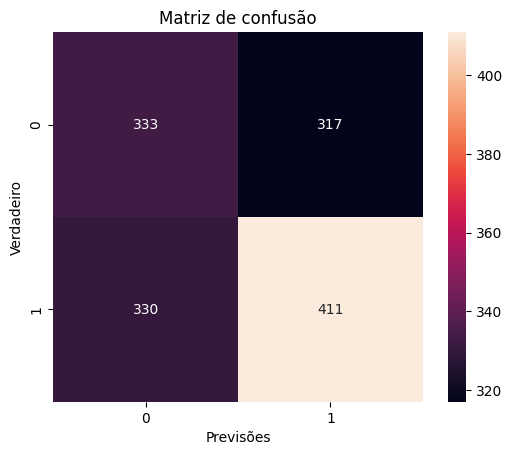

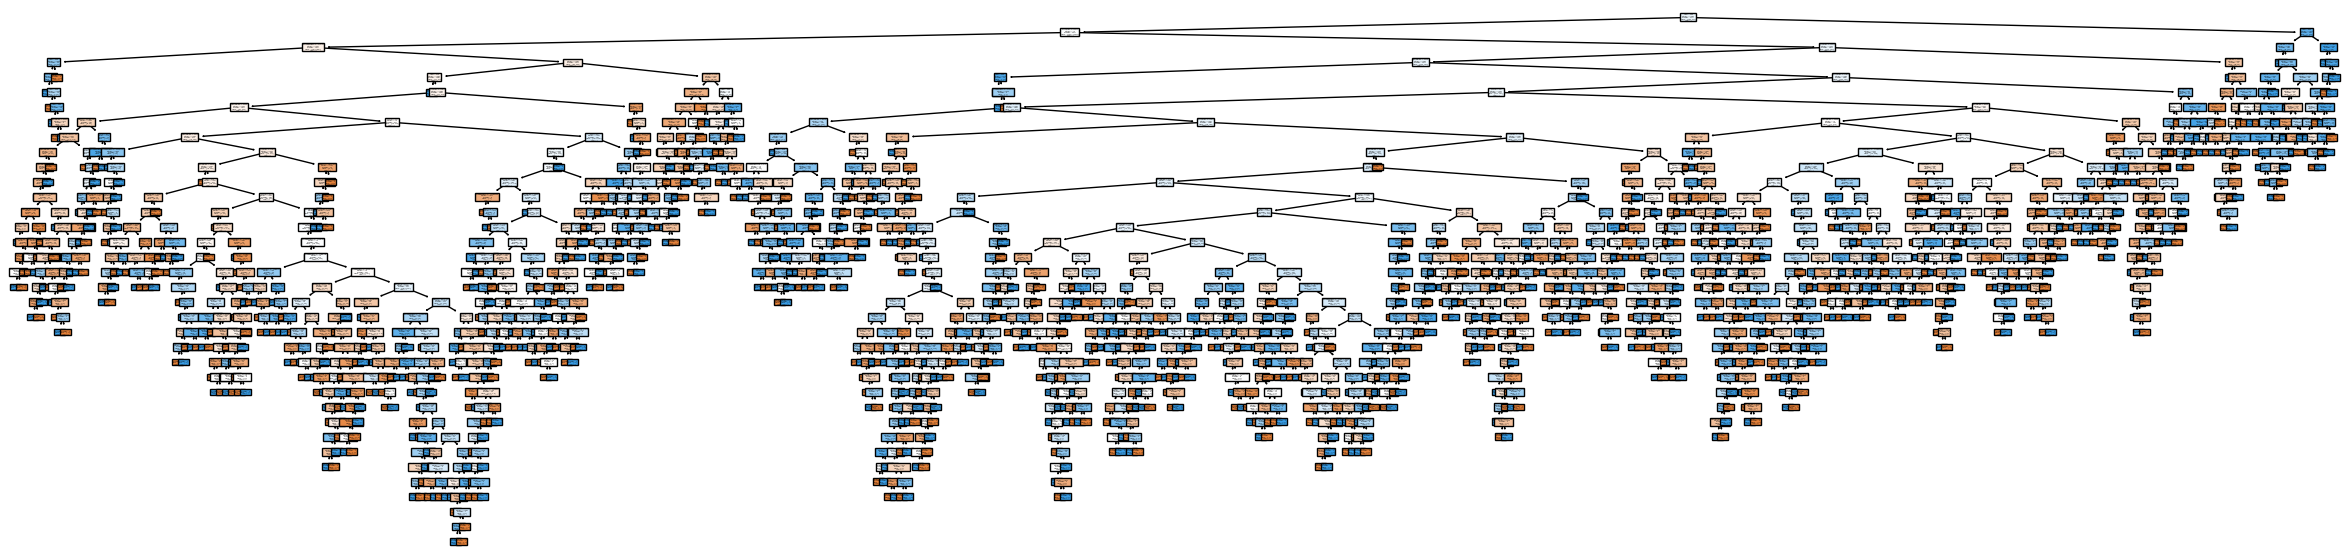

In [13]:
# Criando a arvore de decisao por entropia
model_ent = tree.DecisionTreeClassifier(criterion='entropy')
model_ent.fit(x_train, y_train)

# Realizando o teste
predicted_model_ent = model_ent.predict(x_test)
accuracia_model_ent = accuracy_score(y_test, predicted_model_ent)
print(f"Acurácia: {(accuracia_model_ent * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_ent = confusion_matrix(y_test, predicted_model_ent)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_ent, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Exibindo a arvore de decisao
class_names_str = [str(cls) for cls in model_ent.classes_]
plt.figure(figsize=(30, 7))
plot_tree(model_ent,
        feature_names=atributos.columns,
        class_names=class_names_str,  
        filled=True)
plt.show()

# Serializar
with open('modelos/geral/dados_serializados_model_ent.pickle', 'wb') as arquivo:
    serializar_assinar(model_ent, b'M4Mm]_g#{T', arquivo)
    
    
# desserializar
with open('modelos/geral/dados_serializados_model_ent.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

###### Regressão Logística

c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\italorizzo-ieg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Acurácia: 50.54%


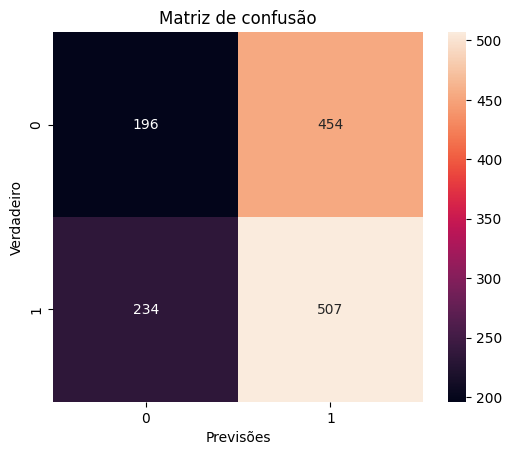

In [14]:
# Criando o modelo
model_lr = LogisticRegression()
model_lr.fit(x_train, y_train)

# Realizando o teste
predicted_model_lr = model_lr.predict(x_test)
accuracia_model_lr = accuracy_score(y_test, predicted_model_lr)
print(f"Acurácia: {(accuracia_model_lr * 100):.2f}%")

# Calculando a matriz de confusao
matriz_confusao_rl = confusion_matrix(y_test, predicted_model_lr)

# Exibindo a matriz de confusao
sns.heatmap(matriz_confusao_rl, fmt='.4g', square=True, annot=True)
plt.xlabel('Previsões')
plt.ylabel('Verdadeiro')
plt.title('Matriz de confusão')
plt.show()

# Serializar
with open('modelos/geral/dados_serializados_model_lr.pickle', 'wb') as arquivo:
    serializar_assinar(model_lr, b'M4Mm]_g#{T', arquivo)
    
    
# desserializar
with open('modelos/geral/dados_serializados_model_lr.pickle', 'rb') as arquivo:
    dados_desserializados = desserializar_e_verificar(b'M4Mm]_g#{T', arquivo)

### Acurácia dos classificadores

In [15]:
print(f"Acurácia por Naive Bayes: {(accuracia_model_nb * 100):.4f}%")
print(f"Acurácia por Gini: {(accuracia_model_gini * 100):.4f}%")
print(f"Acurácia por Entropia: {(accuracia_model_ent * 100):.4f}%")
print(f"Acurácia por Regressão Logística: {(accuracia_model_lr * 100):.4f}%")

Acurácia por Naive Bayes: 51.2581%
Acurácia por Gini: 53.2710%
Acurácia por Entropia: 53.4867%
Acurácia por Regressão Logística: 50.5392%
